In [1]:
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import random_split
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
labels = {
    0: "buildings",
    1: "forest",
    2: "glacier",
    3: "mountain",
    4: "sea",
    5: "street"
}

In [24]:
transform_train= transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

transform_test= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])

train_ds = torchvision.datasets.ImageFolder(root= "../input/intel-image-classification/seg_train/seg_train", 
                                      transform=transform_train)

test_ds = torchvision.datasets.ImageFolder(root= "../input/intel-image-classification/seg_test/seg_test", 
                                           transform=transform_test)

In [22]:
train_ds_size = 12631
val_ds_size = 1403
train_ds, val_ds = random_split(ds, [train_ds_size, val_ds_size])

In [23]:
batch_size = 128
train_dl = DataLoader(ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [7]:
# def show_sample(img, target, invert=True):
#     if invert:
#         plt.imshow(1 - img.permute((1, 2, 0)))
#     else:
#         plt.imshow(img.permute(1, 2, 0))
#     print('Labels:', decode_target(target, text_labels=True))
    
# show_sample(*train_ds[200])

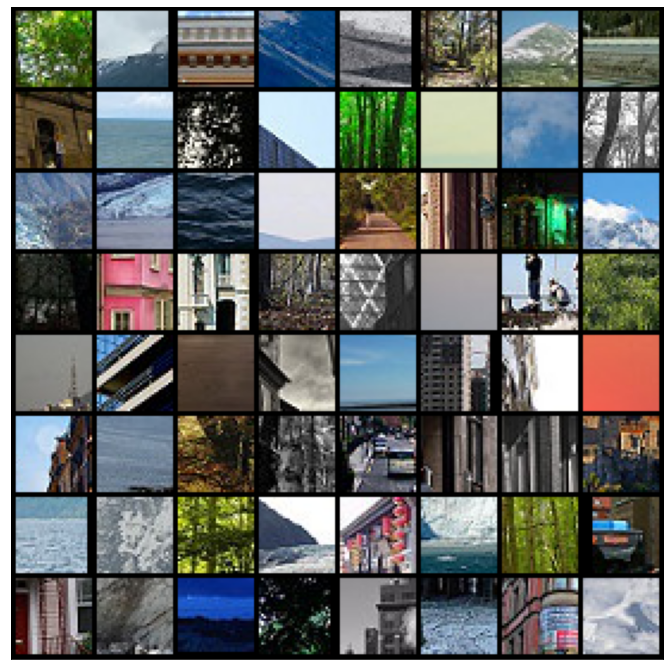

In [8]:
def show_batch(train_dl):
    for images, labels in train_dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
        break
show_batch(train_dl)

Define Model

In [9]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
            print("Epoch: [{}], last_lr: {:.8f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))

In [10]:
class IntelResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        number_of_features = self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, 10)
        
    def forward(self, xb):
        return self.network(xb)
        
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad = False
        for param in self. network.fc.parameters():
            param.require_grad = True
            
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad = True

In [11]:
class IntelModel(ImageClassificationBase):
    
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        
        nn.Conv2d(16, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        
        nn.Flatten(),
        nn.Linear(256*2*2, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 10))
        
    def forward(self, xb):
        return self.cnn(xb)
    
model = IntelModel()
model

IntelModel(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=128, bias=True)
    (16): ReLU()
    (17): Linear(in_features=128, out_features=10, bias=Tru

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [15]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
model_resnet34 = to_device(IntelResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [17]:
history = [evaluate(model_resnet34, val_dl)]
history
history = [evaluate(model_resnet34, val_dl)]
history
model_resnet34.freeze()
epochs = 5
max_lr = 10e-3
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

In [18]:
history += fit_one_cycle(epochs, max_lr, model_resnet34, train_dl, val_dl,
             grad_clip=grad_clip, weight_decay=weight_decay,
             opt_func=opt_func)

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [0], last_lr: 0.00757341, train_loss: 1.3205, val_loss: 8.0057, val_acc: 0.3061


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [1], last_lr: 0.00950485, train_loss: 1.3687, val_loss: 1.6994, val_acc: 0.3284


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [2], last_lr: 0.00611262, train_loss: 1.3175, val_loss: 1.4950, val_acc: 0.3878


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [3], last_lr: 0.00188258, train_loss: 1.2014, val_loss: 1.5364, val_acc: 0.4229


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [4], last_lr: 0.00000004, train_loss: 1.1139, val_loss: 1.0991, val_acc: 0.5668


In [20]:
model_resnet34.unfreeze()
epochs = 10
max_lr = 10e-5
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = fit_one_cycle(epochs, max_lr, model_resnet34, train_dl, val_dl,
             grad_clip=grad_clip, weight_decay=weight_decay,
             opt_func=opt_func)

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [0], last_lr: 0.00002774, train_loss: 1.0776, val_loss: 1.0787, val_acc: 0.5618


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [1], last_lr: 0.00007587, train_loss: 1.0701, val_loss: 1.0313, val_acc: 0.5800


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [2], last_lr: 0.00010000, train_loss: 1.0625, val_loss: 1.0463, val_acc: 0.5827


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [3], last_lr: 0.00009505, train_loss: 1.0506, val_loss: 1.0051, val_acc: 0.5865


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [4], last_lr: 0.00008117, train_loss: 1.0468, val_loss: 1.0228, val_acc: 0.5939


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [5], last_lr: 0.00006113, train_loss: 1.0276, val_loss: 0.9738, val_acc: 0.6200


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [6], last_lr: 0.00003887, train_loss: 1.0107, val_loss: 0.9794, val_acc: 0.6270


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [7], last_lr: 0.00001883, train_loss: 1.0086, val_loss: 0.9805, val_acc: 0.6054


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [8], last_lr: 0.00000495, train_loss: 0.9985, val_loss: 0.9889, val_acc: 0.5998


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: [9], last_lr: 0.00000000, train_loss: 0.9934, val_loss: 0.9610, val_acc: 0.6117


In [ ]:
def plot_accuracy(history):
    scores = [x["val_acc"] for x in history]
    plt.plot(scores, "-x")
    plt.xlabel("epoch")
    plt.ylabel("val_acc")
    plt.title("Accuracy vs. number of epochs")

plot_accuracy(history)

In [ ]:
def plot_loss(history):
    loss = [x["val_loss"] for x in history]
    plt.plot(loss, "-x")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs. number of epochs")
    
plot_loss(history)